In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


# load the data

In [2]:
X_train_1=np.load(file='C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/X_train_1.npy')/255
X_test_1=np.load(file='C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/X_test_1.npy')/255
Y_train_1=np.load(file='C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/Y_train_1.npy')
Y_test_1=np.load(file='C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/Y_test_1.npy')

# data augmentation


Adding small perturbations or changes to the training data can, on the one hand, increase the training data and thus improve the generalization ability of the model, and on the other hand, increase the noise data and thus enhance the robustness of the model.

In [3]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [6]:
# define three metrics:recall,precision and f1 score for the training data
import tensorflow.keras.backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
#set the epoch,learning rate,batch size and the image size
EPOCHS = 5
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224,224))
image_size = 0
#directory_root = '/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease'
width=224
height=224
depth=3
inputShape = (height, width, depth)
n_classes=15

In [11]:
#get the test accuracy and save the model
def Res_Plot_Test_Save(name):
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(X_test_1, Y_test_1)
    print(f"Test Accuracy: {scores[1]*100}")
    print("[INFO] Saving model")
    model.save(name)

# inception V3

One of the notable features of Inception v3 is the use of "Inception modules." These modules consist of multiple parallel convolutional layers with different filter sizes, allowing the network to capture features at various scales. This multi-scale processing helps the model to learn more diverse and robust representations of the input images.

Inception v3 also incorporates other techniques to optimize performance, such as factorized convolutions, which reduce computational complexity, and batch normalization, which improves training stability and speeds up convergence.

In [16]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
# model = tf.keras.backend.clear_session()


# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(224,224,3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=['accuracy', f1_m,  precision_m, recall_m]) 
# model.summary()

Use HPC to run 50 epoches


In [17]:
# train the network. 
print("[INFO] training INCEPTION network...")
history = model.fit(
    aug.flow(X_train_1, Y_train_1, batch_size=BS),
    validation_data=(X_test_1, Y_test_1),
    steps_per_epoch=len(X_train_1) // BS,
    epochs=50
    )

[INFO] training INCEPTION network...
Epoch 1/5
73/73 [==============================] - 119s 2s/step - loss: 0.1972 - accuracy: 0.4195 - f1_m: 0.2888 - precision_m: 0.5434 - recall_m: 0.2113 - val_loss: 0.1383 - val_accuracy: 0.5651 - val_f1_m: 0.5235 - val_precision_m: 0.7116 - val_recall_m: 0.4179
Epoch 2/5
73/73 [==============================] - 139s 2s/step - loss: 0.1200 - accuracy: 0.6625 - f1_m: 0.6549 - precision_m: 0.7940 - recall_m: 0.5614 - val_loss: 0.1230 - val_accuracy: 0.6328 - val_f1_m: 0.6345 - val_precision_m: 0.7750 - val_recall_m: 0.5398
Epoch 3/5
73/73 [==============================] - 133s 2s/step - loss: 0.1027 - accuracy: 0.7145 - f1_m: 0.7064 - precision_m: 0.7951 - recall_m: 0.6371 - val_loss: 0.1089 - val_accuracy: 0.6802 - val_f1_m: 0.6762 - val_precision_m: 0.7716 - val_recall_m: 0.6039
Epoch 4/5
73/73 [==============================] - 129s 2s/step - loss: 0.0902 - accuracy: 0.7424 - f1_m: 0.7460 - precision_m: 0.8122 - recall_m: 0.6914 - val_loss: 0.104

In [ ]:
#display the training and validation output for each epoch under three metrics we defined before.

import matplotlib.pyplot as plt
import numpy as np
import os

def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)
    
    epochs = np.arange(1, len(training) + 1)
    
    plt.plot(epochs, training, 'bo-', label='Train')
    plt.plot(epochs, validation, 'ro-', label='Val')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    
    filename = 'inception_{}.png'.format(yaxis)
    plt.savefig(filename)
    print('Figure saved as {}'.format(os.path.abspath(filename)))
    
    plt.show()


In [ ]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision')
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall')
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score')

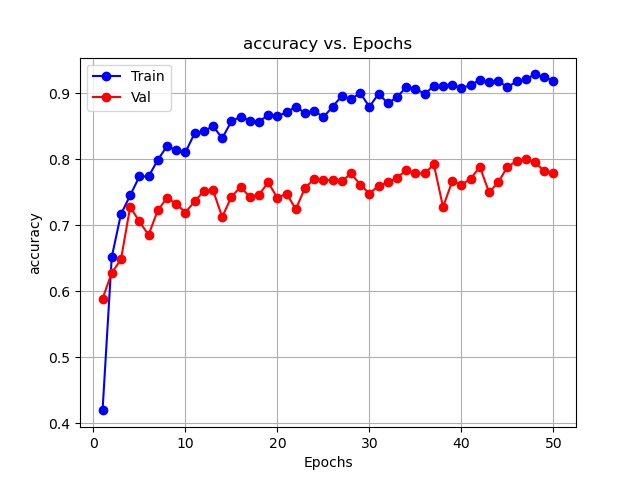

In [1]:
from IPython import display
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/inception_accuracy.png')

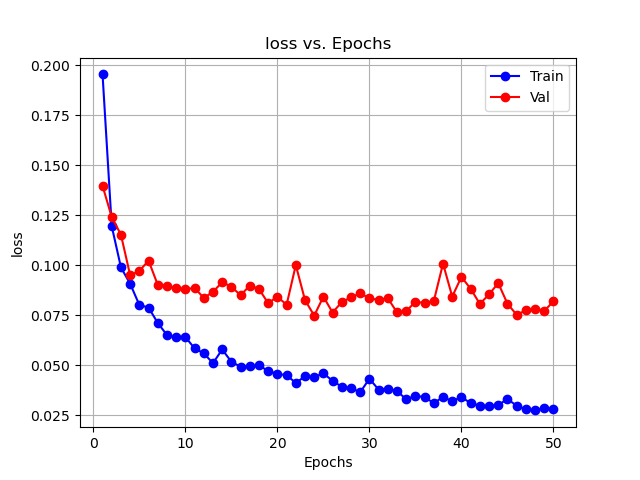

In [2]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/inception_loss.png')

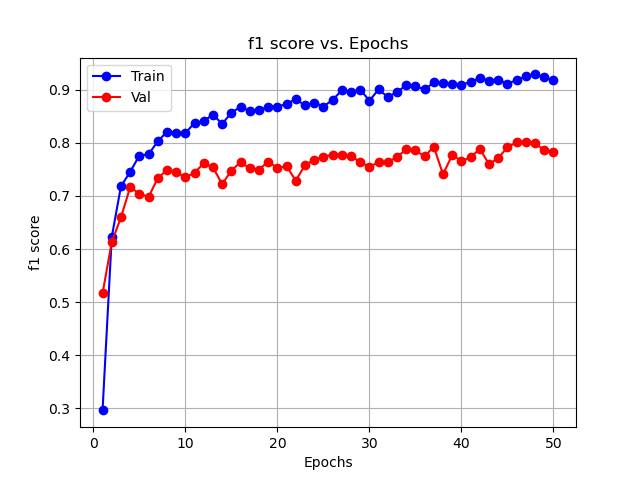

In [3]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/inception_f1 score.png')

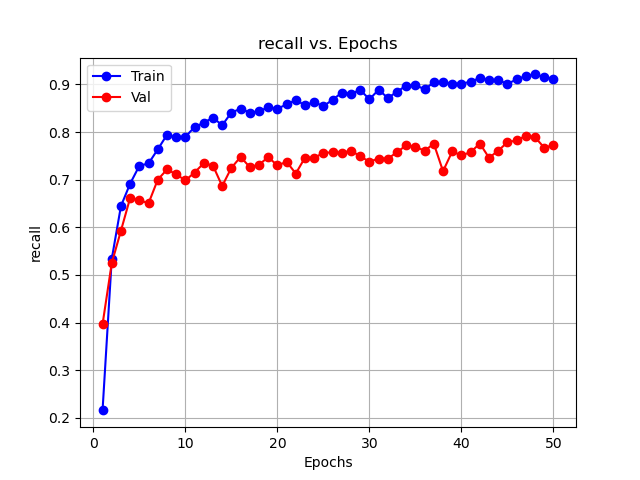

In [4]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/inception_recall.png')

Inception achieved a higher and stable accuracy of around 80%, with a gradually decreasing loss curve and a fast convergence rate.

However, there are large differences between training and validaition data. It suggests that the model has memorized the training data too well and is not generalizing effectively to unseen data. This is a clear sign of overfitting. To address this, techniques such as regularization (e.g., dropout, weight decay), data augmentation, or reducing model complexity may be employed.

In [19]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_1, Y_test_1, verbose=0)
print("Accuracy: {} \nLoss:{} \nF1_score: {} \nPrecision: {} \nRecall: {}".format(accuracy, loss, f1_score, precision, recall))

Accuracy: 0.6971235275268555 
Loss:0.10055771470069885 
F1_score: 0.7101378440856934 
Precision: 0.7582329511642456 
Recall: 0.668749988079071


In [40]:
Res_Plot_Test_Save('Inception_ModelV3_(Imagenet_Weights).h5')

[INFO] Calculating model accuracy
19/19 [==============================] - 9s 502ms/step - loss: 0.1334 - accuracy: 0.6091 - f1_m: 0.5373 - precision_m: 0.7673 - recall_m: 0.4172
Test Accuracy: 60.913705825805664
[INFO] Saving model


# Resnet 50

The name "ResNet50" reflects the structure of the model. "ResNet" stands for Residual Network, which refers to the use of residual connections within the network. The number "50" indicates that the model consists of 50 layers, including convolutional layers, pooling layers, fully connected layers, and shortcut connections.

The key innovation of ResNet50 is the introduction of residual connections, which allow the network to learn residual mappings. These connections enable the network to bypass certain layers, helping to address the degradation problem that occurs when deep networks suffer from diminishing performance with increasing depth. By utilizing residual connections, ResNet50 can train deeper networks more effectively and achieve better accuracy.


In [20]:
from keras.models import Model
from keras import applications
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
model = tf.keras.backend.clear_session()

# Get the Resnet model so we can do transfer learning
base_model = ResNet50(weights= None, include_top=False, input_shape= (224,224,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=['accuracy', f1_m,  precision_m, recall_m]) 
# model.summary()

In [ ]:
# train the network
print("[INFO] training RESNET network...")
history = model.fit_generator(
    aug.flow(X_train_1, Y_train_1, batch_size=BS),
    validation_data=(X_test_1, Y_test_1),
    steps_per_epoch=len(X_train_1) // BS,
    epochs=50
    )

In [ ]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision')
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall')
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score')

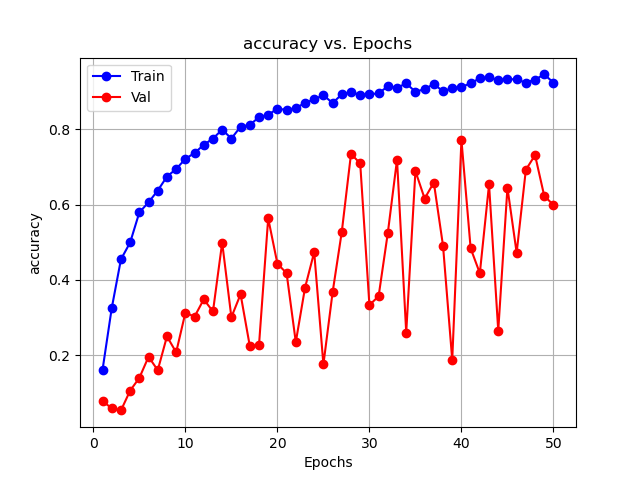

In [5]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/resnet_accuracy.png')

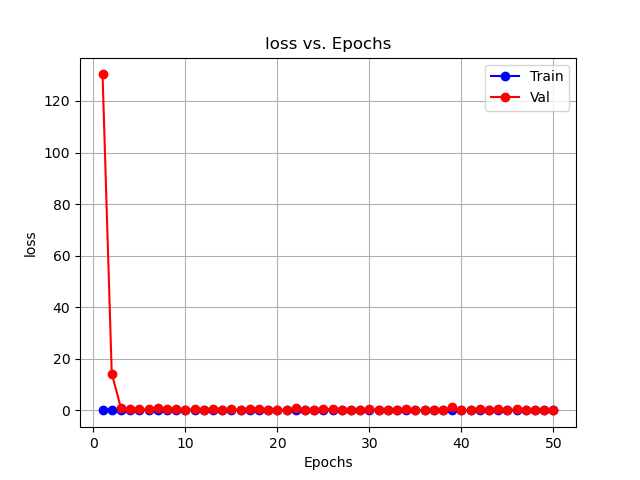

In [6]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/resnet_loss.png')

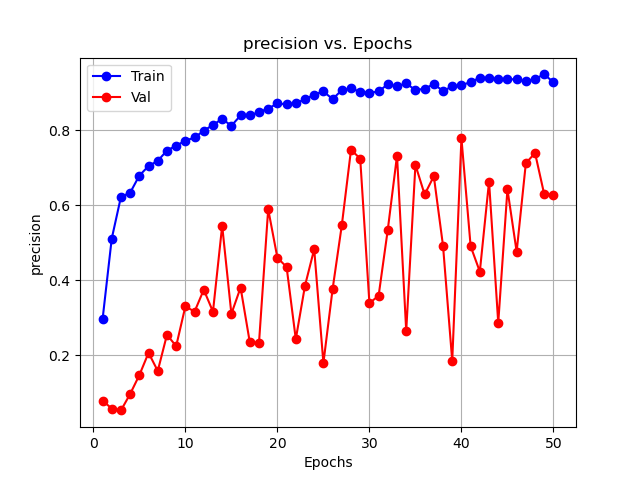

In [7]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/resnet_precision.png')

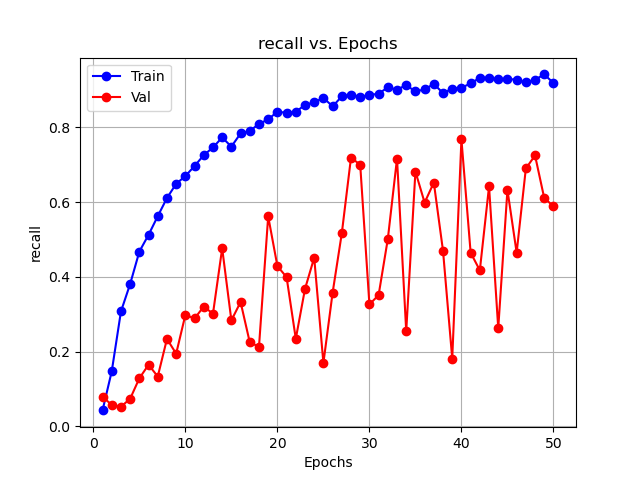

In [8]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/resnet_recall.png')

The accuracy is low and exhibited significant fluctuations, indicating possible issues of overfitting or underfitting. 

In [48]:
Res_Plot_Test_Save('ResNet_(Imagenet_Weights).h5')

[INFO] Calculating model accuracy
19/19 [==============================] - 13s 617ms/step - loss: 0.3345 - accuracy: 0.0592 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Test Accuracy: 5.922165885567665
[INFO] Saving model


# VGG16 Model

The "VGG" in VGG16 stands for the research group that developed the model, and "16" represents the total number of layers in the network. VGG16 is characterized by its uniform architecture, where the convolutional layers consist of 3x3 filters with a stride of 1, and the pooling layers utilize 2x2 filters with a stride of 2.

VGG16 achieved significant breakthroughs in image recognition and classification by demonstrating that deeper neural networks can improve performance. It was one of the first models to highlight the importance of depth in CNN architectures. 

In [24]:
from keras.models import Model
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
model = tf.keras.backend.clear_session()
# Get the vgg16 model so we can do transfer learning
base_model = vgg16.VGG16(weights= None, include_top=False, input_shape= (224,224,3))
# model= None                          
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=['accuracy', f1_m,  precision_m, recall_m]) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# train the network. 
print("[INFO] training VGG16 network...")
history = model.fit(
    aug.flow(X_train_1, Y_train_1, batch_size=BS),
    validation_data=(X_test_1, Y_test_1),
    steps_per_epoch=len(X_train_1) // BS,
    epochs=1
    )

In [ ]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision')
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall')
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score')

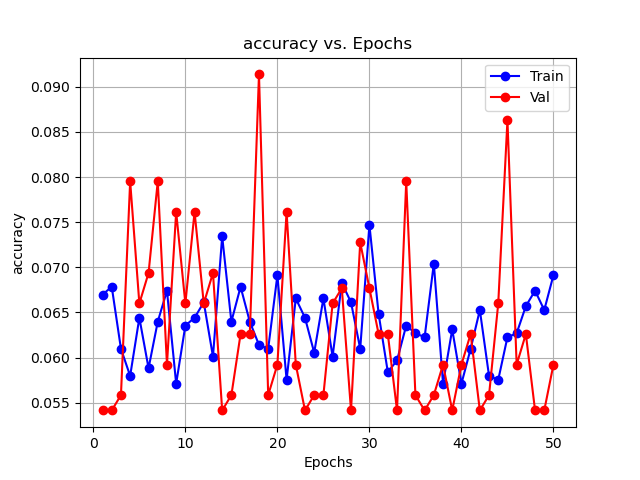

In [9]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/vgg_accuracy.png')

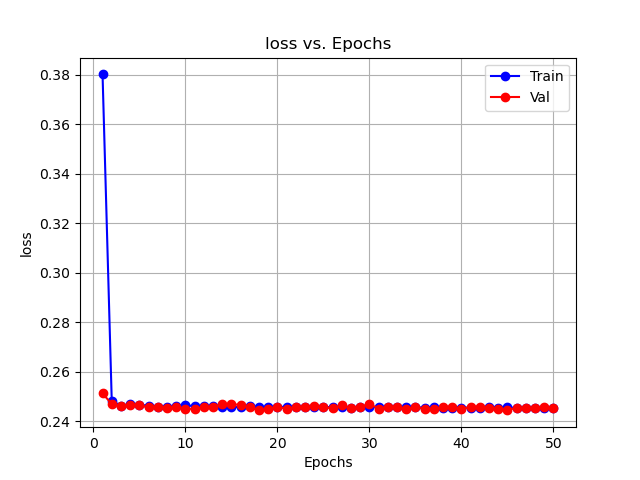

In [10]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/vgg_loss.png')

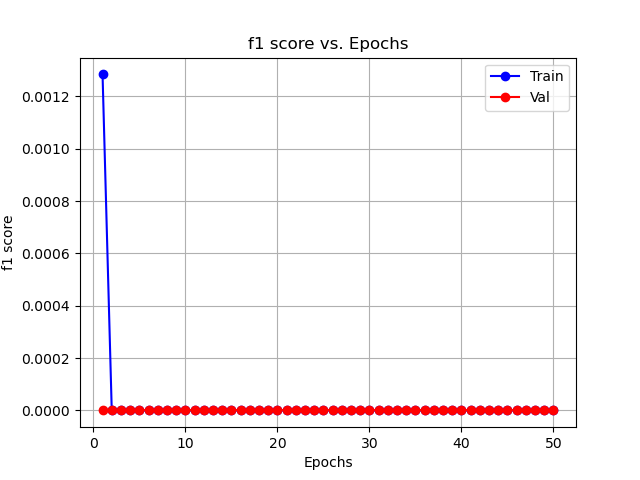

In [11]:
display.Image('C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/plant output hpc/vgg_f1 score.png')

The accuracy is unstable and even the training curve does not converge, which may because:

The model architecture may be too complex for the given training data, leading to overfitting. 

A learning rate that is too high can prevent the model from converging to an optimal solution, leading to fluctuations in accuracy.

The batch size is too small.

In [ ]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test_1, Y_test_1, verbose=0)
print("Accuracy: {} \nLoss:{} \nF1_score: {} \nPrecision: {} \nRecall: {}".format(accuracy, loss, f1_score, precision, recall))

In [ ]:
Res_Plot_Test_Save('VGG16_(Imagenet_Weights).h5')